## Reproducing the Educational Example (see Appendix A) of the paper PhysRevX.12.011059 by Sivak et al.

We want to implement a Reinforcement Learning (RL) model (which is a classical Neural Network) and train its agent to learn the rotation angle $\theta$ to flip the incoming quantum state $\ket{0}$ to the $\ket{1}$ state by applying a RX-gate($\theta$).

This code is implemented in ``PyTorch`` and bases its architecture on the one by Mr. Arthur Strauss who used ``TensorFlow`` (https://github.com/arthurostrauss/Quantum_Optimal_Control/tree/main/paper_results)

#### Imports

In [347]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm
from scipy.linalg import sqrtm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.optim as optim

from qiskit import QuantumCircuit
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi

#### The RL agent performs an action

To measure in the Hadamard basis (or X-basis), you can use the Hadamard gate. Specifically, before performing the measurement on a qubit prepared in a certain state, apply a Hadamard gate. This gate transforms the state from the computational (Z) basis to the Hadamard (X) basis. After applying the Hadamard gate, you can measure in the usual Z-basis, which effectively corresponds to a measurement in the X-basis.

**To measure the $\ket{+}$ state in the Hadamard basis:**

- Apply a Hadamard gate on the qubit that's in the $\ket{+}$ state.
- Measure in the computational basis ($\ket{0}$ and $\ket{1}$).
- The outcome of the measurement is then in the Hadamard basis.

**To measure the $\ket{-}$ state in the Hadamard basis:**

- Apply a z-gate on the qubit
- Apply a Hadamard gate on the qubit that's in the $\ket{-}$ state.
- Measure in the computational basis ($\ket{0}$ and $\ket{1}$).
- The outcome of the measurement is then in the Hadamard basis.

Estimate a density matrix based on the binary (either 0 or 1) measurement outcomes of the quantum circuit

In [348]:
target_states = {
    '1': np.array([0, 1]),
    '+': (1/np.sqrt(2)) * np.array([+1, +1]),
    '-': (1/np.sqrt(2)) * np.array([+1, -1]),
}

In [349]:
def get_dm(state: np.ndarray) -> np.ndarray:
    return np.outer(state, np.conj(state))

def get_fidelity(rho, sigma):
    """
    Compute the fidelity between two quantum states represented by density matrices.
    
    Parameters:
    - rho (numpy.ndarray): Density matrix of the first quantum state.
    - sigma (numpy.ndarray): Density matrix of the second quantum state.
    
    Returns:
    - float: Fidelity between the two quantum states.
    
    Note:
    This function assumes that the input density matrices are valid (positive, trace 1) and of the same size.
    """
    
    # Computing the square root of rho
    sqrt_rho = sqrtm(rho)
    
    # Calculating the product sqrt_rho * sigma * sqrt_rho
    temp_product = np.dot(np.dot(sqrt_rho, sigma), sqrt_rho)
    
    # Taking the square root of the product
    root_product = sqrtm(temp_product)
    
    # Calculating the trace and squaring it
    fidelity = np.real(np.trace(root_product))**2
    
    return fidelity

# Testing with example pure states, here orthogonal states (F = 0)
psi = np.array([1, 0])
phi = np.array([1, 0])

psi_dm = get_dm(state=psi)
phi_dm = get_dm(state=phi)

print(f'Fidelity F = {round(get_fidelity(psi_dm, phi_dm), 6)}')  # This should be close to 0 for orthogonal states

Fidelity F = 1.0


In [350]:
def estimate_dm(qc, estimated_dm, batch) -> np.ndarray:
    # Construct the estimated density matrix
    q_state = qi.Statevector.from_instruction(qc)
    estimated_dm += np.array(q_state.to_operator()) / batch 

    return estimated_dm

In [351]:
target_state_str = '1'

target_state = target_states[target_state_str]
print('Target state:', target_state)

Target state: [0 1]


In [352]:
def perform_action(amp, shots=1, target_state_str=target_state_str):
    """
    Execute a quantum circuit with parametrized amplitude, retrieve measurement result and assign rewards accordingly
        
        :param amp: amplitude parameter, provided as an array of size batchsize
        :param shots: number of evaluations to be done on the quantum computer
        :param target: string indicating the target state ('1' or '+')
    
        :return: Reward table (reward for each run in the batch)
    """
    global qc, qasm, target_states
    angles, batch = np.array(amp), len(np.array(amp))
    reward_table = np.zeros(batch)

    estimated_dm = np.zeros([2, 2], dtype='complex128')

    for ind, angle in enumerate(angles):
        if target_state_str == '1':
            qc.rx(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch
            estimate_dm(qc, estimated_dm, batch)
            
        elif target_state_str in ['+', '-']:
            qc.ry(2 * np.pi * angle, 0)  # Add parametrized gate for each amplitude in the batch  
            estimate_dm(qc, estimated_dm, batch)
            qc.h(0) # Transform to hadamard basis before measurement
        
        qc.measure(0, 0)  # Measurement
        job = qasm.run(qc, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)  # Returns a dict with keys '0' and '1' (possible measurement outcomes) with number of counts for each key
        
        # Calculate reward
        if target_state_str == '1':
            reward_table[ind] += np.mean(np.array([1] * counts.get('1', 0) + [-1] * counts.get('0', 0)))
        elif target_state_str == '+':
            reward_table[ind] += np.mean(np.array([1] * counts.get('0', 0) + [-1] * counts.get('1', 0)))
        elif target_state_str == '-':
            reward_table[ind] += np.mean(np.array([1] * counts.get('1', 0) + [-1] * counts.get('0', 0)))
        else:
            if ind % 10 == 0:
                print('Reward calculation FAILS')

        qc.clear()

    return reward_table, estimated_dm

#### Set Hyperparameters for the RL

In [368]:
# Variables to define environment
qc = QuantumCircuit(1, 1)  # Two-level system of interest, 1 qubit
qasm = QasmSimulator(method="statevector")  # Simulation backend (mock quantum computer)

seed = 2364

# Hyperparameters for the agent
n_epochs = 60
batch_size = 50

use_PPO = True

eta = 0.1  # Learning rate for policy update step
critic_loss_coeff = 0.5

epsilon = 0.2  # Parameter for ratio clipping value (PPO)
grad_clip = 0.3
sigma_eps = 1e-6

Policy Parameters (From a Gaussian Distribution)

In [ ]:
mu = torch.nn.Parameter(torch.randn([]) * 0.05, requires_grad=True)
mu_old = torch.clone(mu).detach().requires_grad_(False)

sigma = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)
sigma_old = torch.clone(sigma).detach().requires_grad_(False)

b = torch.nn.Parameter(torch.tensor(0.0), requires_grad=True)

print('Initial Parameters')
print('-------------------------')
print('\nmu: ', mu.item())
print('sigma: ', sigma.item())
print('b: ', b.item())

In [ ]:
optimizer_string = "Adam"

# Define the optimizer based on optimizer_string
if optimizer_string == "Adam":
    optimizer = optim.Adam([mu, sigma, b], lr=eta)
elif optimizer_string == "SGD":
    optimizer = optim.SGD([mu, sigma, b], lr=eta)

Value Constrains for the Gaussian Policy Parameters

In [ ]:
def constrain_mu(value):
    return torch.clamp(value, -1., +1.)

def constrain_sigma(value):
    return torch.clamp(value, sigma_eps, 1.5)

Keeping track of all variables

In [1]:
#  Keep track of variables
params = {
    "means": np.zeros(n_epochs),
    "stds": np.zeros(n_epochs),
    "amps": np.zeros([n_epochs, batch_size]),
    "rewards": np.zeros([n_epochs, batch_size]),
    "critic_loss": np.zeros(n_epochs),
    "fidelity": np.zeros(n_epochs),
    "grads": np.zeros((n_epochs, 3)),
    "hyperparams": {
        "learning_rate": eta,
        "seed": seed,
        "clipping_PPO": epsilon,
        "grad_clip_value": grad_clip,
        "n_epochs": n_epochs,
        "batch_size": batch_size,
        "target_state": (target_state_str, target_states[target_state_str]),
        "PPO?": use_PPO,
        "critic_loss_coeff": critic_loss_coeff,
        "optimizer": optimizer_string

    }
}

NameError: name 'np' is not defined

#### Training

In [ ]:
# Logging of intermediate Training Results
def log_info(epoch, mu, sigma, reward, target_state, fidelity):
    print('\nEPOCH', epoch+1)
    print('Policy parameter')
    print(f'mu = {mu.item()} +- sigma = {sigma.item()}')
    print('baseline', b.item())
    print('Average Return:', reward.mean().item())
    print(f'Target state: |{target_state}>')
    print('Fidelity: ', fidelity)

In [365]:
for epoch in tqdm(range(n_epochs)):
    normal_distrib = Normal.Normal(mu, sigma)
    normal_distrib_old = Normal.Normal(mu_old, sigma_old)
    a = normal_distrib.sample((batch_size,))

    # Run quantum circuit to retrieve rewards (in this example, only one time step)
    reward, dm_observed = perform_action(a, shots=1, target_state=target_state_str)
    print("Average Return:", reward.mean().item())

    # Assuming you have defined a model for your actor and critic, let's compute the loss and gradients
    # The following code assumes you have a model and an optimizer defined. Here, we're just focusing on the loss calculation.
    optimizer.zero_grad()

    advantage = torch.tensor(reward) - b
    if use_PPO:
        ratio = normal_distrib.log_prob(a).exp() / (normal_distrib_old.log_prob(a).exp() + sigma_eps)
        clipped_ratio = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
        actor_loss = - torch.mean(torch.min(advantage * ratio, advantage * clipped_ratio))
    else:  # REINFORCE algorithm
        log_probs = normal_distrib.log_prob(a)
        actor_loss = - torch.mean(advantage * log_probs)

    critic_loss = torch.mean(advantage ** 2)

    combined_loss = actor_loss + critic_loss_coeff * critic_loss
    combined_loss.backward()

    # Clipping gradients (if needed)
    torch.nn.utils.clip_grad_norm_([mu, sigma, b], grad_clip)

    # For PPO, update old parameters to have access to "old" policy
    if use_PPO:
        mu_old.data = mu.data.clone()
        sigma_old.data = sigma.data.clone()

    # Apply gradients
    optimizer.step()

    params["amps"][epoch] = np.array(a.cpu().detach())
    params["rewards"][epoch] = reward
    params["means"][epoch] = np.array(mu.item())
    params["stds"][epoch] = np.array(sigma.item())
    params["critic_loss"][epoch] = np.array(critic_loss.cpu().detach())
    params["fidelity"][epoch] = get_fidelity(get_dm(target_states[target_state_str]), dm_observed)
    params["grads"][epoch] = np.array([param.grad for param in [mu, sigma, b]])

    # Log intermediate results of the training process
    if epoch % 10 == 0:
        log_info(epoch, mu, sigma, reward, target_state_str, params["fidelity"][epoch])

  5%|▌         | 5/100 [00:00<00:02, 45.74it/s]


EPOCH 1
Policy parameter
mu = 0.0015395615482702851 +- sigma = 1.0
baseline 0.0
Average Return: 0.0
Target state:  [0 1]
Fidelity:  0.4627704447349832


 16%|█▌        | 16/100 [00:00<00:01, 46.20it/s]


EPOCH 11
Policy parameter
mu = 0.16019214689731598 +- sigma = 0.7705815434455872
baseline 0.9859116077423096
Average Return: 0.12
Target state:  [0 1]
Fidelity:  0.518884445938458

EPOCH 21
Policy parameter
mu = 0.5165491104125977 +- sigma = 1.2578202486038208
baseline 1.8000987768173218
Average Return: 0.04
Target state:  [0 1]
Fidelity:  0.5161479066651556


 40%|████      | 40/100 [00:00<00:01, 54.05it/s]


EPOCH 31
Policy parameter
mu = 0.7965592741966248 +- sigma = 1.4689100980758667
baseline 2.017775058746338
Average Return: 0.28
Target state:  [0 1]
Fidelity:  0.5421652387208861

EPOCH 41
Policy parameter
mu = 0.8902525901794434 +- sigma = 1.4224268198013306
baseline 1.9868487119674683
Average Return: 0.28
Target state:  [0 1]
Fidelity:  0.6312393470876584


 58%|█████▊    | 58/100 [00:01<00:00, 53.82it/s]


EPOCH 51
Policy parameter
mu = 1.0 +- sigma = 1.1688034534454346
baseline 1.8510477542877197
Average Return: 0.12
Target state:  [0 1]
Fidelity:  0.5296435948211796

EPOCH 61
Policy parameter
mu = 0.9575299620628357 +- sigma = 1.210425853729248
baseline 1.7255921363830566
Average Return: -0.04
Target state:  [0 1]
Fidelity:  0.451254707207748


 76%|███████▌  | 76/100 [00:01<00:00, 52.12it/s]


EPOCH 71
Policy parameter
mu = 0.7706577777862549 +- sigma = 1.2135460376739502
baseline 1.8525296449661255
Average Return: 0.12
Target state:  [0 1]
Fidelity:  0.5639368411843567

EPOCH 81
Policy parameter
mu = 0.378173828125 +- sigma = 1.2784886360168457
baseline 1.7678308486938477
Average Return: 0.12
Target state:  [0 1]
Fidelity:  0.5030349919075081


100%|██████████| 100/100 [00:01<00:00, 51.98it/s]


EPOCH 91
Policy parameter
mu = 0.5196916460990906 +- sigma = 1.1668226718902588
baseline 1.7727296352386475
Average Return: 0.16
Target state:  [0 1]
Fidelity:  0.4683321377893683


#### Visualization

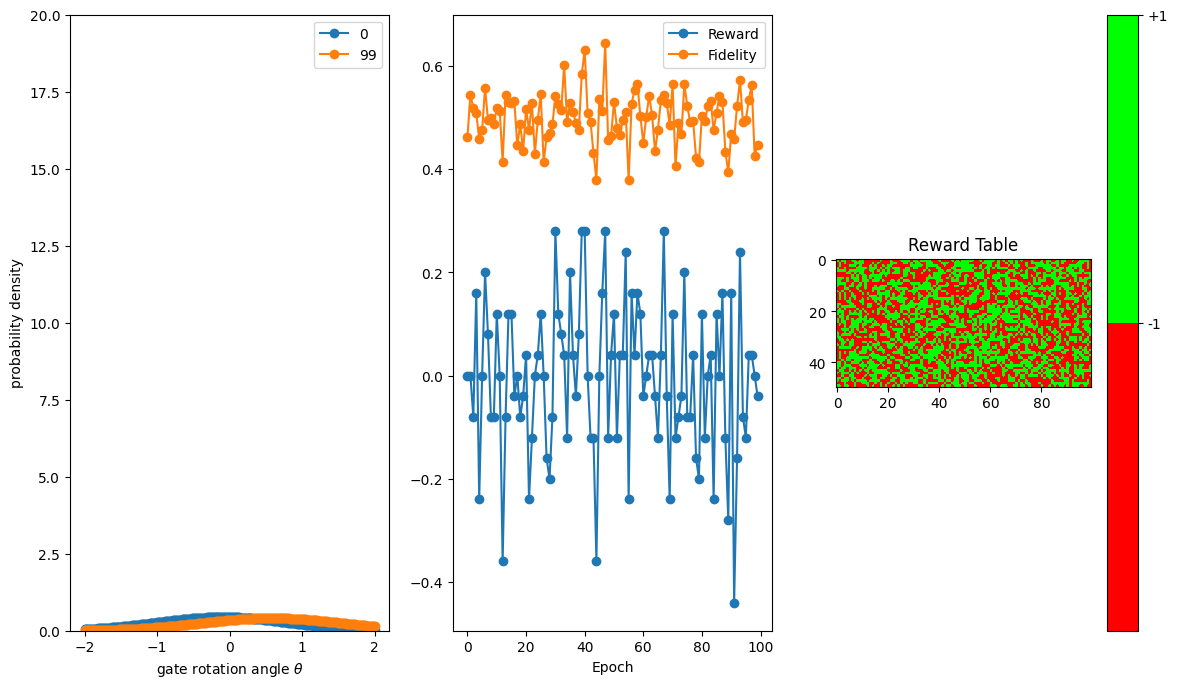

In [369]:
x = np.linspace(-2., 2., 300)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 8))

visualization_step = n_epochs//50
# Plot probability density associated to updated parameters for a few steps
for ind in np.linspace(0, n_epochs-1, visualization_step, dtype=int):
    ax1.plot(x, norm.pdf(x, loc=params["mu"][ind], scale=np.abs(params["sigma"][ind])), '-o', label=f'{ind}')

ax1.set_xlabel(r"gate rotation angle $\theta$")
ax1.set_ylabel("probability density")
ax1.set_ylim(0., 20)
#  Plot return as a function of epochs
ax2.plot(np.mean(params["reward"], axis=1), '-o', label='Reward')
ax2.plot(params["fidelity"], '-o', label='Fidelity')
ax2.set_xlabel("Epoch")
ax2.legend()
ax1.legend()

rewards = np.array(params['reward']).transpose()
# Create a custom colormap
colors = [(1, 0, 0), (0, 1, 0)]  # R -> G
cmap_name = 'custom_red_green'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=2)

# Dummy data and imshow for ax3
cax = ax3.imshow(rewards, cmap=cm)
ax3.set_title("Reward Table")

# Add colorbar to ax3
cbar = fig.colorbar(cax, ax=ax3, ticks=[0, 1])
cbar.ax.set_yticklabels(['-1', '+1'])

plt.show()